# Оформление проекта

- карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени
- временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.

In [47]:
import numpy as np                               
import pandas as pd 

import geopandas as gpd
from shapely.geometry import Polygon

from bokeh.io import save, show, output_file, output_notebook, reset_output, export_png
from bokeh.plotting import figure
from bokeh.models import (
    GeoJSONDataSource, ColumnDataSource, ColorBar, Slider, Spacer,
    HoverTool, TapTool, Panel, Tabs, Legend, Toggle, LegendItem, Button, TextInput
)
from bokeh.palettes import brewer
from bokeh import events
from bokeh.models.callbacks import CustomJS
from bokeh.models.widgets import Div
from bokeh.layouts import widgetbox, row, column
from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex

from bokeh.tile_providers import Vendors, get_provider
import json

In [2]:
output_notebook()

Loading BokehJS ...

## Read taxi orders count data

In [3]:
df=pd.read_csv('all_data.csv',sep=';')

In [4]:
df = df.set_index('time')

In [5]:
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80,144,50,77,319,402,531,617,846,267,...,12,0,2,44,5,41,4,70,7,66
2016-01-01 01:00:00,91,211,49,134,404,420,370,453,594,224,...,29,0,5,2,2,4,0,47,1,29
2016-01-01 02:00:00,90,146,23,110,393,425,313,366,377,138,...,47,0,3,0,4,0,0,69,1,14
2016-01-01 03:00:00,32,87,16,62,252,399,324,309,327,166,...,46,0,2,4,5,1,0,21,0,9
2016-01-01 04:00:00,24,43,10,53,145,254,264,333,318,145,...,43,0,0,1,1,0,0,26,1,6


### Select data for visualisation

In [6]:
df = df.loc['2016-06-01 00':'2016-06-03 00']

In [7]:
df.columns = df.columns.astype(int)

In [8]:
df_cols = df.columns.tolist()

### Create full 2500 regions grid

In [9]:
full_df=pd.DataFrame(index=df.index, columns=np.arange(1, 2501))

In [10]:
for x in df_cols:
    full_df[x] = df[x]

In [11]:
full_df.fillna(0, inplace=True)

In [12]:
full_df.reset_index(inplace=True)

In [13]:
full_df.head()

,time,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-06-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-06-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-06-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-06-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-06-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# expand data
data = pd.DataFrame(columns=['region', 'time','val'])
for i in range(1, len(full_df.columns)):
    dt_temp = pd.DataFrame(columns=['region', 'time','val'])
    dt_temp['time'] = full_df.time.values
    dt_temp['val'] = full_df[full_df.columns[i]].values
    dt_temp['region'] = [full_df.columns[i]] * full_df.shape[0]
    
    data = data.append(dt_temp)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 47
Data columns (total 3 columns):
region    120000 non-null object
time      120000 non-null object
val       120000 non-null object
dtypes: object(3)
memory usage: 3.7+ MB


In [16]:
data['time'] = data['time'].str.replace(':00:00','')

In [17]:
data

,region,time,val
0,1,2016-06-01 00,0
1,1,2016-06-01 01,0
2,1,2016-06-01 02,0
3,1,2016-06-01 03,0
4,1,2016-06-01 04,0
...,...,...,...
43,2500,2016-06-02 19,0
44,2500,2016-06-02 20,0
45,2500,2016-06-02 21,0
46,2500,2016-06-02 22,0


### Load forecasted data from week 6

In [21]:
forecast = pd.read_csv('forecast_final_w6.csv')

In [22]:
forecast.head(2)

,id,y
0,1075_2016-05-31_23_1,45.124287
1,1075_2016-05-31_23_2,25.875452


In [23]:
forecast['y'] = forecast['y'].astype(int)

In [24]:
forecast["region"] = forecast["id"].apply(lambda x: x[0:4]).astype(int)

In [25]:
forecast["time"] = forecast["id"].apply(lambda x: x[5:18]).astype(str)

In [26]:
forecast["f_time"] = forecast["id"].apply(lambda x: x[-1:]).astype(str)

In [27]:
t1 = ['_0_', '_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_', '_8_', '_9_', '_10', '_11','_12','_13','_14','_15','_16','_17','_18','_19','_20','_21','_22','_23']
t2 = [' 00', ' 01', ' 02', ' 03', ' 04', ' 05', ' 06', ' 07', ' 08', ' 09', ' 10', ' 11', ' 12', ' 13', ' 14', ' 15', ' 16', ' 17', ' 18', ' 19', ' 20', ' 21', ' 22', ' 23']

for o, n in zip(t1, t2):
    forecast['time'] = forecast['time'].str.replace(o, n)

In [28]:
forecast.drop(columns=['id'], inplace=True)

In [29]:
forecast = forecast.rename(columns={'y': 'val'})

In [30]:
regions = pd.read_csv('regions.csv', delimiter=';')

In [31]:
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


### Converting Coordinate Reference Systems to epsg3857-web-mercator

In [32]:
#def lon_to_web_mercator(lon):
#    k = 6378137
#    return lon * (k * np.pi / 180.0)

#def lat_to_web_mercator(lat):
#    k = 6378137
#    return np.log(np.tan((90 + lat) * np.pi / 360.0)) * k- 

In [33]:
regions['west'] = regions['west'] * (6378137 * np.pi / 180.0)
regions['east'] = regions['east'] * (6378137 * np.pi / 180.0)
regions['south'] = np.log(np.tan((90 + regions['south']) * np.pi / 360.0)) * 6378137
regions['north'] = np.log(np.tan((90 + regions['north']) * np.pi / 360.0)) * 6378137

### Calculate grid coordinates and create geopandas Polygons

In [34]:
ul = list(zip(regions.west, regions.north))
ur = list(zip(regions.east, regions.north))
lr = list(zip(regions.east, regions.south))
ll = list(zip(regions.west, regions.south))

In [35]:
geom=[]
for i in range(regions.shape[0]):
    poly = [ul[i], ur[i], lr[i], ll[i], ul[i]]
    geom.append(Polygon(poly))

In [36]:
regions['geometry'] = geom

In [37]:
regions.head()

,region,west,east,south,north,geometry
0,1,-8.266094e+06,-8.264858e+06,4.938301e+06,4.939529e+06,POLYGON ((-8266094.467354097 4939529.175069497...
1,2,-8.266094e+06,-8.264858e+06,4.939529e+06,4.940757e+06,POLYGON ((-8266094.467354097 4940757.323391667...
2,3,-8.266094e+06,-8.264858e+06,4.940757e+06,4.941986e+06,POLYGON ((-8266094.467354097 4941985.625359734...
3,4,-8.266094e+06,-8.264858e+06,4.941986e+06,4.943214e+06,POLYGON ((-8266094.467354097 4943214.081038475...
4,5,-8.266094e+06,-8.264858e+06,4.943214e+06,4.944443e+06,POLYGON ((-8266094.467354097 4944442.690492717...


### Merge regions coordinates with real data

In [38]:
f_data = pd.merge(data, regions, on='region')

In [39]:
f_data.drop(columns=['west', 'east', 'south', 'north'], inplace=True)

In [40]:
f_data.head()

,region,time,val,geometry
0,1,2016-06-01 00,0,POLYGON ((-8266094.467354097 4939529.175069497...
1,1,2016-06-01 01,0,POLYGON ((-8266094.467354097 4939529.175069497...
2,1,2016-06-01 02,0,POLYGON ((-8266094.467354097 4939529.175069497...
3,1,2016-06-01 03,0,POLYGON ((-8266094.467354097 4939529.175069497...
4,1,2016-06-01 04,0,POLYGON ((-8266094.467354097 4939529.175069497...


### Merge regions coordinates with forecasted data

In [41]:
f2_data = pd.merge(forecast, regions, on='region')

In [42]:
f2_data.drop(columns=['west', 'east', 'south', 'north'], inplace=True)

In [43]:
f2_data.head()

,val,region,time,f_time,geometry
0,45,1075,2016-05-31 23,1,POLYGON ((-8240118.776622228 4969047.272516431...
1,25,1075,2016-05-31 23,2,POLYGON ((-8240118.776622228 4969047.272516431...
2,12,1075,2016-05-31 23,3,POLYGON ((-8240118.776622228 4969047.272516431...
3,8,1075,2016-05-31 23,4,POLYGON ((-8240118.776622228 4969047.272516431...
4,8,1075,2016-05-31 23,5,POLYGON ((-8240118.776622228 4969047.272516431...


In [45]:
#import pickle
#data.to_pickle('f_data.pkl')
#data.to_pickle('f2_data.pkl')

In [ ]:
#with open('exp_data.pkl', 'rb') as f:
#    data = pickle.load(f)
#data = pickle.load('exp_data.pkl')

### Create GeoDataFrames

In [44]:
g_df  = gpd.GeoDataFrame(f_data)

In [45]:
g_df2 = gpd.GeoDataFrame(f2_data)

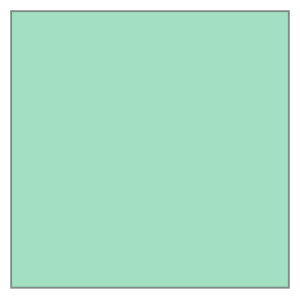

In [46]:
g_df2.geometry[50]

In [47]:
g_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 4 columns):
region      120000 non-null object
time        120000 non-null object
val         120000 non-null object
geometry    120000 non-null geometry
dtypes: geometry(1), object(3)
memory usage: 4.6+ MB


### Create bins to color each region

In [48]:
bins = [0,5,50,100,500,1000,1500,2500]
# create stylish labels
bin_labels = [f'≤{bins[1]}'] + [f'{bins[i]}-{bins[i+1]}' for i in range(1,len(bins)-2)] + [f'>{bins[-2]}']
# assign each row to a bin
g_df['bin'] = pd.cut(
    g_df['val'], bins=bins, right=True, include_lowest=True, precision=0, labels=bin_labels,
).astype(str)

In [49]:
g_df2['bin'] = pd.cut(
    g_df2['val'], bins=bins, right=True, include_lowest=True, precision=0, labels=bin_labels,
).astype(str)

In [50]:
# Define a yellow to red color palette
palette = brewer['YlOrRd'][len(bins)-1]
# Reverse color order so that dark red corresponds to highest obesity
palette = palette[::-1]

# Assign texi reaquests to a color
def val_to_color(value, nan_color='#d9d9d9'):
    if isinstance(value, str): return nan_color
    for i in range(1,len(bins)):
        if value <= bins[i]:
            return palette[i-1]
g_df['color'] = g_df['val'].apply(val_to_color)

In [51]:
g_df2['color'] = g_df2['val'].apply(val_to_color)

In [52]:
g_df.head(2)

,region,time,val,geometry,bin,color
0,1,2016-06-01 00,0,"POLYGON ((-8266094.467 4939529.175, -8264857.5...",≤5,#ffffb2
1,1,2016-06-01 01,0,"POLYGON ((-8266094.467 4939529.175, -8264857.5...",≤5,#ffffb2


In [53]:
# assign x coordinates
def bin_to_cbar_x(value):
    if value == 'No data': return -2
    for i,b in enumerate(bin_labels):
        if value == b:
            return 5*(i+1)
g_df['cbar_x'] = g_df['bin'].apply(bin_to_cbar_x)
# assign width
#g_df['cbar_w'] = g_df['val'].apply(lambda x: 5 if x == 'No data' else 4.7)
g_df['cbar_w'] = 4.7

In [54]:
g_df2['cbar_x'] = g_df2['bin'].apply(bin_to_cbar_x)
# assign width
#g_df['cbar_w'] = g_df['val'].apply(lambda x: 5 if x == 'No data' else 4.7)
g_df2['cbar_w'] = 4.7

In [55]:
g_df.head(2)

,region,time,val,geometry,bin,color,cbar_x,cbar_w
0,1,2016-06-01 00,0,"POLYGON ((-8266094.467 4939529.175, -8264857.5...",≤5,#ffffb2,5,4.7
1,1,2016-06-01 01,0,"POLYGON ((-8266094.467 4939529.175, -8264857.5...",≤5,#ffffb2,5,4.7


In [56]:
# create color palette for the graph
zones = sorted(df.columns.unique())
n_zones = len(zones)
print("%d zones to plot" % n_zones)
cmap = plt.get_cmap('gist_ncar', n_zones)
country_palette = [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

102 zones to plot


## Plotting

In [57]:
# define the output file
reset_output()
output_file("taxi-orders.html", title="NY Taxi orders", mode="inline")

In [58]:
# source that will contain all necessary data for the map
geosource = GeoJSONDataSource(geojson=g_df.to_json())

# source that contains the data that is actually shown on the map (for a given year)
displayed_src = GeoJSONDataSource(geojson=g_df[g_df['time'] == '2016-06-01 00'].to_json())

# source that will be used for the graph (we don't need the countries shapes for this)
zone_source = ColumnDataSource(g_df[g_df['region'] == 1].drop(columns=["geometry"]))

In [59]:
geosource2 = GeoJSONDataSource(geojson=g_df2.to_json())
displayed_src2 = GeoJSONDataSource(geojson=g_df2[(g_df2['time'] == '2016-06-01 00') & (g_df2['f_time'] == '1')].to_json())
zone_source2 = ColumnDataSource(g_df2[g_df2['region'] == 1075].drop(columns=["geometry"]))

The tools displayed with our map and graph.

In [60]:
# Tools

button = Button(label="Show", button_type="success")
button2 = Button(label="Show", button_type="success")

text_input = TextInput(value="2016-06-01 00", title="Enter Date and Time:")
text_input2 = TextInput(value="2016-06-01 00", title="Enter Date and Time:")

# hover tool for the map
map_hover = HoverTool(tooltips=[ 
    ('Region','@region'),
    ('Taxi requests', '@val')
])

# hover tool for the graph
graph_hover = HoverTool(tooltips=[ 
    ('Region','@region'),
    ('Taxi requests', '@val'),
    ('Time', '@time')
])

Now let's create the plot !

In [61]:
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

In [62]:
# create map figure
p = figure(
    title = 'NY Yellow Taxi real requests', 
    plot_height=600 , plot_width=600,
    #x_range=(-8260000, -8190000), 
    #y_range=(4940000, 5020000),
    toolbar_location="right", tools="tap,pan,wheel_zoom,box_zoom,save,reset", toolbar_sticky=False,
    active_scroll="wheel_zoom",
    x_axis_type="mercator", 
    y_axis_type="mercator"
)
p.title.text_font_size = '16pt'
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = True
p.add_tile(tile_provider)


# Add hover tool
p.add_tools(map_hover)

# Add patches (regions) to the figure
patches = p.patches(
    'xs','ys', source=displayed_src, 
    fill_color='color',
    line_color='black', line_width=0.25, fill_alpha=0.45, 
    hover_fill_color='color',
)


# outline when we hover over a country
patches.hover_glyph.line_color = '#3bdd9d'
patches.hover_glyph.line_width = 3
patches.nonselection_glyph = None

In [63]:
#show(p)

In [64]:
# create map figure for prediction
p2 = figure(
    title = 'NY Yellow Taxi predicted requests',
    plot_height=600 , plot_width=600,
    #x_range=(-8260000, -8190000), 
    #y_range=(4940000, 5020000),
    toolbar_location="right", tools="tap,pan,wheel_zoom,box_zoom,save,reset", toolbar_sticky=False,
    active_scroll="wheel_zoom",
    x_axis_type="mercator", 
    y_axis_type="mercator"
)
p2.title.text_font_size = '16pt'
p2.xgrid.grid_line_color = None
p2.ygrid.grid_line_color = None
p2.axis.visible = True
p2.add_tile(tile_provider)


# Add hover tool
p2.add_tools(map_hover)

# Add patches (regions) to the figure
patches2 = p2.patches(
    'xs','ys', source=displayed_src2, 
    fill_color='color',
    line_color='black', line_width=0.25, fill_alpha=0.45, 
    hover_fill_color='color'
)


# outline when we hover over a country
patches2.hover_glyph.line_color = '#3bdd9d'
patches2.hover_glyph.line_width = 3
patches2.nonselection_glyph = None

In [65]:
#show(p2)

In [66]:
# create the interactive colorbar
p_bar = figure(
    title=None, plot_height=80 , plot_width=600, 
    tools="tap", toolbar_location=None
)
p_bar.xgrid.grid_line_color = None
p_bar.ygrid.grid_line_color = None
p_bar.outline_line_color = None
p_bar.yaxis.visible = False

# set the title and ticks of the colorbar
p_bar.xaxis.axis_label = "Range of taxi requests"
p_bar.xaxis.ticker = sorted(g_df['cbar_x'].unique())
p_bar.xaxis.major_label_overrides = dict([(i[0],i[1]) for i in g_df.groupby(['cbar_x','bin']).describe().index])
p_bar.xaxis.axis_label_text_font_size = "12pt"
p_bar.xaxis.major_label_text_font_size = "10pt"

# activate the hover but hide tooltips
hover_bar = HoverTool(tooltips=None)
p_bar.add_tools(hover_bar)

# plot the rectangles for the colorbar
cbar = p_bar.rect(x='cbar_x', y=0, width='cbar_w', height=1, 
    color='color', source=displayed_src,
    hover_line_color='#3bdd9d', hover_fill_color='color')

# outline when we hover over the colorbar legend
cbar.hover_glyph.line_width = 4
cbar.nonselection_glyph = None

In [67]:
# create the graph figure
p_region = figure(
    title="Taxi requests", plot_height=700 , plot_width=1100, 
    tools="pan,wheel_zoom,save", active_scroll="wheel_zoom", toolbar_location="right",
    x_range = g_df['time'][(g_df['region'] == 1075) & (g_df['time'].str.contains("2016-06-01"))].values
)

p_region.title.text_font_size = '14pt'
p_region.xaxis.axis_label = "Time, hours"
p_region.yaxis.axis_label = "Taxi requests count"
p_region.axis.major_label_text_font_size = "12pt"
p_region.axis.axis_label_text_font_size = "14pt"
p_region.xaxis.major_label_orientation = np.pi/2

# plot data on the figure
line_plots = {}
line_plots2 = {}
legend_items = {}
legend_items2 = {}
for i, zone in enumerate(zones):
    
    # get subset of data corresponding to a country
    zone_source = ColumnDataSource(g_df[(g_df['region'] == zone) & (g_df['time'].str.contains("2016-06-01"))].drop(columns=["geometry"]))
    zone_source2 = ColumnDataSource(g_df2[(g_df2['region'] == zone) & (g_df2['time'].str.contains("2016-06-01")) & (g_df2['f_time'] == '1')].drop(columns=["geometry"]))
    
    # plot
    line = p_region.line("time", "val", legend_label=' ',  source=zone_source, 
                      color=country_palette[i], line_width=2)
    circle = p_region.circle("time", "val", legend_label=' ', source=zone_source, 
                          line_color="darkgrey", fill_color=country_palette[i], size=8)
    
    
    # plot
    line2 = p_region.line("time", "val", legend_label=' ',  source=zone_source2, 
                      color=country_palette[i], line_width=2)
    circle2 = p_region.circle("time", "val", legend_label=' ', source=zone_source2, 
                          line_color="red", fill_color='red', size=8)
    
    
    
    # used later in the interactive callbacks
    line_plots[zone] = [line, circle]
    legend_items[zone] = LegendItem(label=str(zone), renderers=[line, circle])
    
    line_plots2[zone] = [line2, circle2]
    legend_items2[zone] = LegendItem(label=str(zone), renderers=[line2, circle2])
    # only display region 1075  at first
    if zone != 1075:
        line.visible = False
        circle.visible = False
        line2.visible = False
        circle2.visible = False
        
default_legend = [
    (str(1075),line_plots[1075]),
    (str(1182),line_plots[1182]),
    (str(1231),line_plots[1231]),
    (str(1230),line_plots[1230]),
    (str(1282),line_plots[1282]),
    (str(1332),line_plots[1332])
]
legend = Legend(items=default_legend, location="top_center")
legend.click_policy = "hide"
p_region.add_layout(legend, 'right')


default_legend2 = [
    (str(1075),line_plots2[1075]),
    (str(1182),line_plots2[1182]),
    (str(1231),line_plots2[1231]),
    (str(1230),line_plots2[1230]),
    (str(1282),line_plots2[1282]),
    (str(1332),line_plots2[1332])
]
legend2 = Legend(items=default_legend2, location="top_center")
legend2.click_policy = "hide"
p_region.add_layout(legend2, 'left')


In [68]:
#show(p_region)

In [69]:
# JS callbacks

# Update the map on button click
button_callback = CustomJS(args=dict(text_input=text_input, source=geosource, displayed_src=displayed_src), code="""
    var time = text_input.value;
    var show = [time, 'No data'];
    var data = {};
    columns = Object.keys(source.data);
    columns.forEach(function(key) {
        data[key] = [];
    });
    for (var i = 0; i < source.get_length(); i++){
        if (show.includes(source.data['time'][i])){
            columns.forEach(function(key) {
                data[key].push(source.data[key][i])
            });
        }
    }
    displayed_src.data = data;
    displayed_src.change.emit();
""")
button.js_on_event(events.ButtonClick, button_callback)


# Update the prediction-map on button click

button_callback2 = CustomJS(args=dict(text_input=text_input2, source=geosource2, displayed_src=displayed_src2), code="""
    var time = text_input.value;
    var show = [time, 'No data'];
    var data = {};
    columns = Object.keys(source.data);
    columns.forEach(function(key) {
        data[key] = [];
    });
    for (var i = 0; i < source.get_length(); i++){
        if (show.includes(source.data['time'][i])){
            columns.forEach(function(key) {
                data[key].push(source.data[key][i])
            });
        }
    }
    displayed_src.data = data;
    displayed_src.change.emit();
""")
button2.js_on_event(events.ButtonClick, button_callback2)


In [70]:
# arrange display with tabs
tab_map = Panel(title="Map - Real Data.",
    child=column(
        p, # map
        p_bar, # colorbar
        row(Spacer(width=10), widgetbox(text_input), widgetbox(button)) # animation button and slider
    ))
tab_map2 = Panel(title="Map - Predicted Data.",
    child=column(
        p2, # map
        p_bar, # colorbar
        row(widgetbox(text_input2), widgetbox(button2)) # animation button and slider
    ))
tab_chart = Panel(title="Chart", child=column(p_region))
tabs = Tabs(tabs=[ tab_map, tab_map2, tab_chart ])

In [71]:
# save the document and display it !
footer = Div(text="""
Вверху 3 вкладки: 1. Карта - реальные данные. 2. Карта - прогноз. 3 - График реальных данных и прогноза.</br>
Данные представлены в диапазоне с 2016-06-01 00 по 2016-06-03 00 (Y-M-D H).</br>
Чтобы посмотреть данные за определенную дату, нужно ввести в поле в формате 2016-06-13 01 и кликнуть Show.</br>
На вкладке прогнозы при наведении указателя на область появляются прогнозы на 1-6 часов.</br>
На вкладке графики представлены графики для некоторых регионов. Включить/выключить график можно кнопкой слева (прогнозируемые данные) и справа (реальные данные). Прогноз представлен на 1 час вперед.</br>
Data: NY Yellow Taxi trip data</br>
<a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page">NYC Taxi and Limousine Commission (TLC)</a></br >
Author: Petr Rubin
""")
layout = column(tabs, footer)


In [72]:
show(layout)